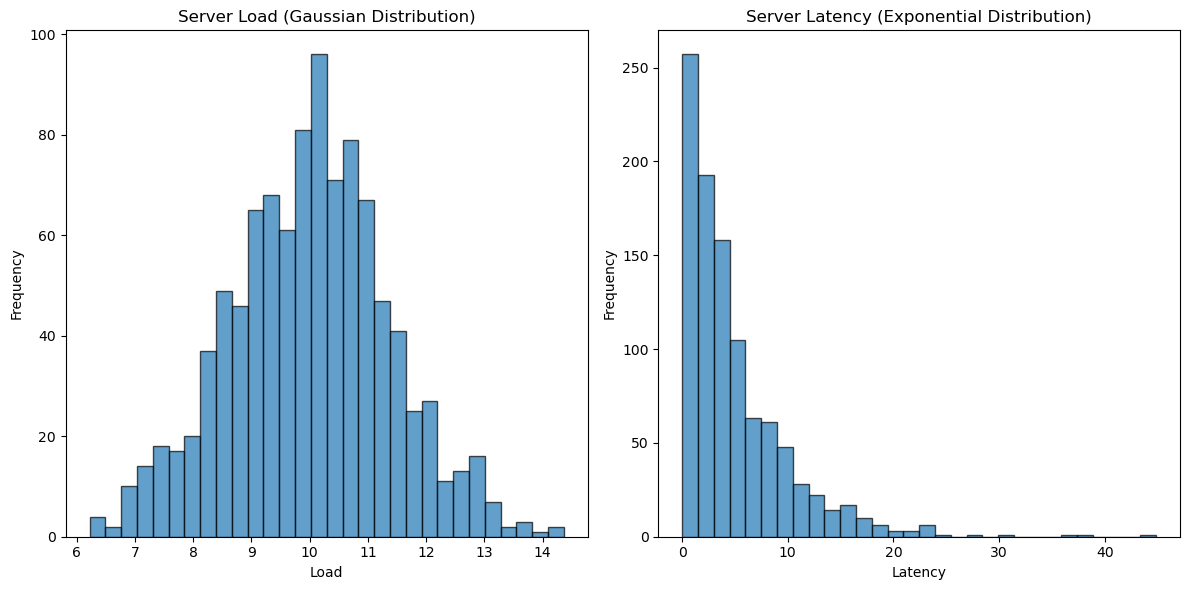

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 参数设置
mean_load = 10  # 高斯分布的均值
variance_load = 2  # 高斯分布的方差
mean_latency = 5  # 指数分布的均值（即1/λ）
num_samples = 1000  # 生成的数据样本数

# 生成服务器负载数据（高斯分布）
load_data = np.random.normal(mean_load, np.sqrt(variance_load), num_samples)

# 生成服务器延迟数据（指数分布）
latency_data = np.random.exponential(mean_latency, num_samples)

# 绘制负载数据的直方图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(load_data, bins=30, edgecolor='black', alpha=0.7)
plt.title('Server Load (Gaussian Distribution)')
plt.xlabel('Load')
plt.ylabel('Frequency')

# 绘制延迟数据的直方图
plt.subplot(1, 2, 2)
plt.hist(latency_data, bins=30, edgecolor='black', alpha=0.7)
plt.title('Server Latency (Exponential Distribution)')
plt.xlabel('Latency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


NameError: name 'all_load_data' is not defined

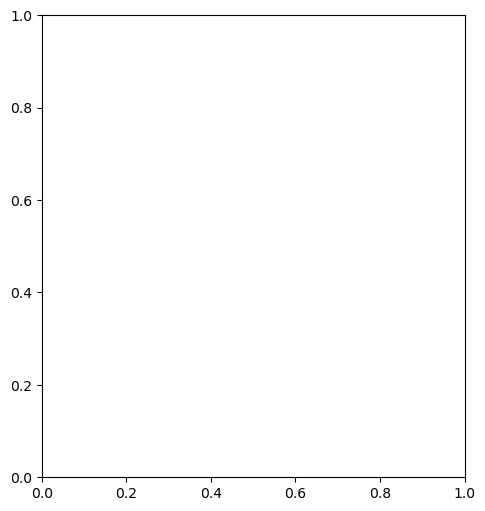

In [2]:
# 可视化第一个节点的负载和延迟数据
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(all_load_data[0])
# plt.hist(all_load_data[0], bins=30, edgecolor='black', alpha=0.7)
plt.title(f'Node 1 Load (Gaussian Distribution)')
plt.xlabel('Load')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(all_latency_data[0])
# plt.hist(all_latency_data[0], bins=30, edgecolor='black', alpha=0.7)
plt.title(f'Node 1 Latency (Exponential Distribution)')
plt.xlabel('Latency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

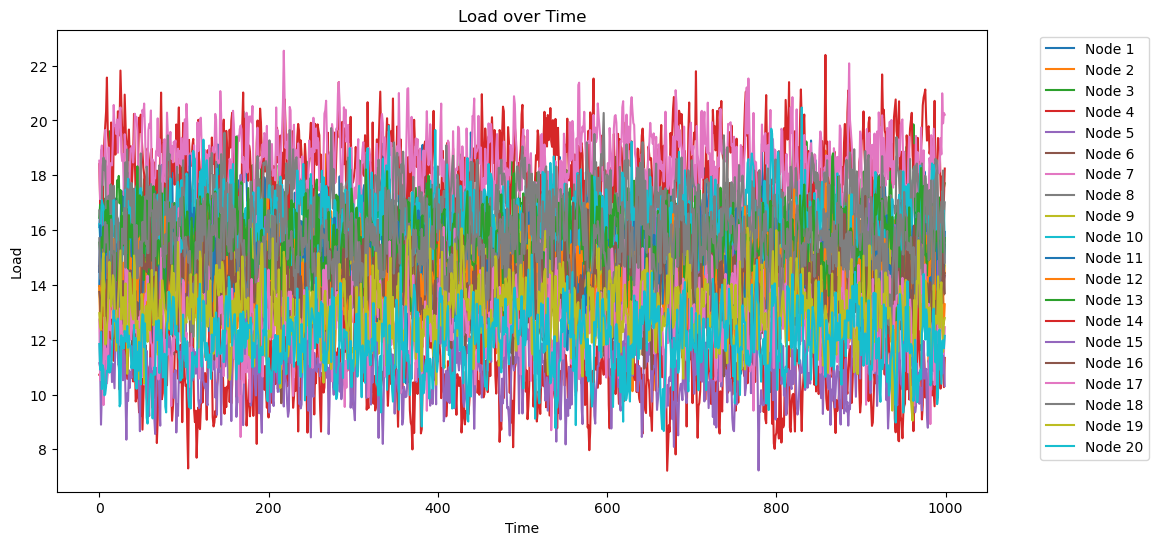

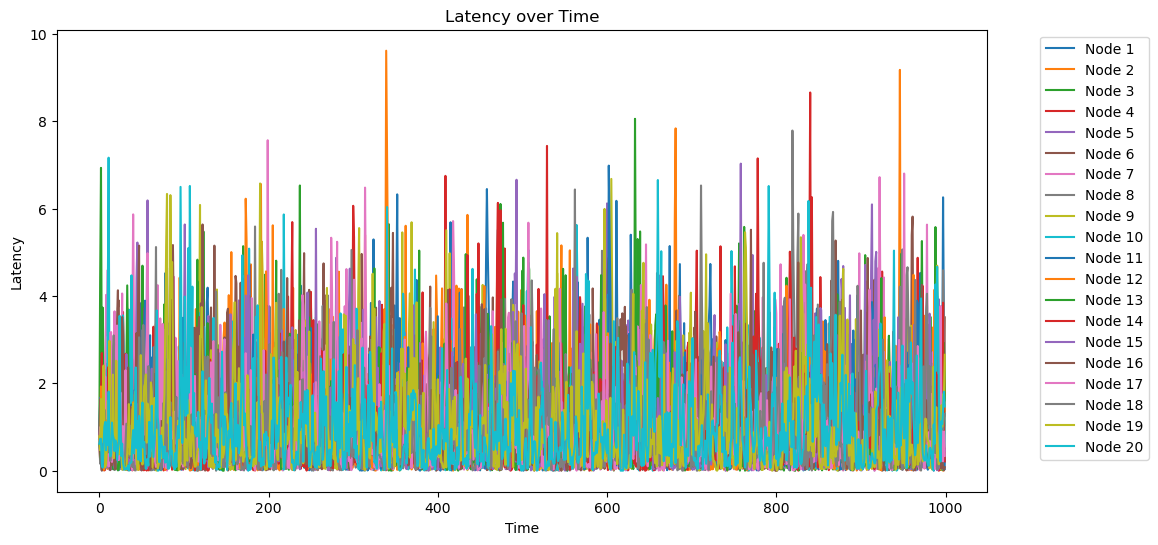

In [4]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# AR(1) Process Parameters
N = 20
T = 1000
mean_load = 15
var_load = 5
mean_latency = 10
var_latency = 2
theta = 0.5

# Generating mean values for each node
np.random.seed(42)
means_load = np.random.normal(loc=mean_load, scale=np.sqrt(var_load), size=N)
means_latency = np.random.normal(loc=mean_latency, scale=np.sqrt(var_latency), size=N)

# Initializing load and latency arrays
load = np.zeros((N, T))

ar1_latency = np.zeros((N, T))
ar1_standardized_latency = np.zeros((N, T))
uniform_latency = np.zeros((N, T))
latency = np.zeros((N, T))


# Generating AR(1) load data
def generate_ar1(theta, n, mean_node):
    ar1 = np.zeros(n)
    ar1[0] = mean_node
    for t in range(1, n):
        ar1[t] = ar1[t - 1] + (1 - theta) * (mean_node - ar1[t - 1]) + np.random.normal(0, 1)
    return ar1


# Generating load data conforming to Gaussian distribution and delay data conforming to exponential distribution
for i in range(N):
    load[i] = generate_ar1(theta, T, means_load[i])

    ar1_latency[i] = generate_ar1(theta, T, means_latency[i])
    ar1_standardized_latency[i] = (ar1_latency[i] - np.mean(ar1_latency[i])) / np.std(ar1_latency[i])
    uniform_latency[i] = norm.cdf(ar1_standardized_latency[i])
    lambda_param = 1
    latency[i] = -np.log(1 - uniform_latency[i]) / lambda_param

# Plotting load data
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(load[i], label=f'Node {i + 1}')
plt.title('Load over Time')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting latency data
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(latency[i], label=f'Node {i + 1}')
plt.title('Latency over Time')
plt.xlabel('Time')
plt.ylabel('Latency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

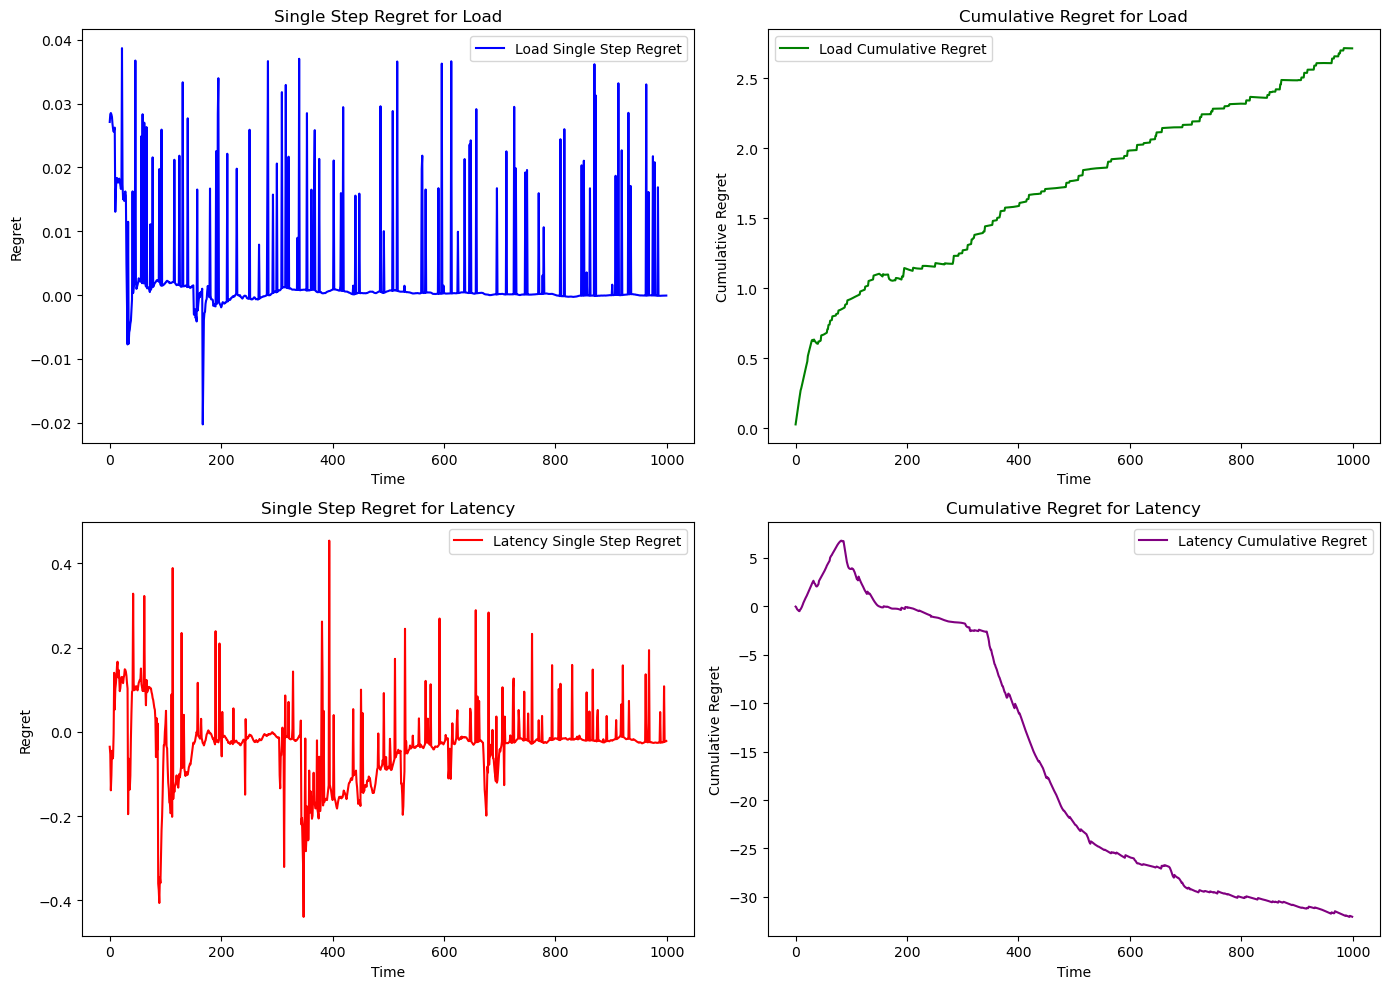

In [5]:
# Epsilon-greedy algorithm
epsilon = 0.1
alpha = 1.0


def epsilon_greedy(epsilon, rewards, estimated_means):
    if np.random.rand() < epsilon:
        return np.random.randint(len(rewards))
    else:
        return np.argmax(estimated_means)


def calculate_regret(true_means, chosen_means):
    mu_star = np.max(true_means)
    regret = mu_star - chosen_means
    return regret


# Calculating rewards and running the epsilon-greedy algorithm
rewards_load = 1 / (1 + load)
rewards_latency = np.exp(-alpha * latency)

estimated_means_load = np.zeros(N)
estimated_means_latency = np.zeros(N)
chosen_counts_load = np.zeros(N)
chosen_counts_latency = np.zeros(N)

cumulative_regret_load = np.zeros(T)
cumulative_regret_latency = np.zeros(T)
single_step_regret_load = np.zeros(T)
single_step_regret_latency = np.zeros(T)

for t in range(T):
    chosen_node_load = epsilon_greedy(epsilon, rewards_load[:, t], estimated_means_load)
    chosen_node_latency = epsilon_greedy(epsilon, rewards_latency[:, t], estimated_means_latency)

    reward_load = rewards_load[chosen_node_load, t]
    reward_latency = rewards_latency[chosen_node_latency, t]

    chosen_counts_load[chosen_node_load] += 1
    chosen_counts_latency[chosen_node_latency] += 1

    estimated_means_load[chosen_node_load] += (reward_load - estimated_means_load[chosen_node_load]) / \
                                              chosen_counts_load[chosen_node_load]
    estimated_means_latency[chosen_node_latency] += (reward_latency - estimated_means_latency[chosen_node_latency]) / \
                                                    chosen_counts_latency[chosen_node_latency]

    single_step_regret_load[t] = calculate_regret(np.mean(rewards_load, axis=1), estimated_means_load[chosen_node_load])
    single_step_regret_latency[t] = calculate_regret(np.mean(rewards_latency, axis=1),
                                                     estimated_means_latency[chosen_node_latency])

    if t == 0:
        cumulative_regret_load[t] = single_step_regret_load[t]
        cumulative_regret_latency[t] = single_step_regret_latency[t]
    else:
        cumulative_regret_load[t] = cumulative_regret_load[t - 1] + single_step_regret_load[t]
        cumulative_regret_latency[t] = cumulative_regret_latency[t - 1] + single_step_regret_latency[t]

# Plotting all four graphs in a single figure
plt.figure(figsize=(14, 10))

# Single Step Regret for Load
plt.subplot(2, 2, 1)
plt.plot(single_step_regret_load, label='Load Single Step Regret', color='blue')
plt.title('Single Step Regret for Load')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.legend()

# Cumulative Regret for Load
plt.subplot(2, 2, 2)
plt.plot(cumulative_regret_load, label='Load Cumulative Regret', color='green')
plt.title('Cumulative Regret for Load')
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.legend()

# Single Step Regret for Latency
plt.subplot(2, 2, 3)
plt.plot(single_step_regret_latency, label='Latency Single Step Regret', color='red')
plt.title('Single Step Regret for Latency')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.legend()

# Cumulative Regret for Latency
plt.subplot(2, 2, 4)
plt.plot(cumulative_regret_latency, label='Latency Cumulative Regret', color='purple')
plt.title('Cumulative Regret for Latency')
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.tight_layout()
plt.show()


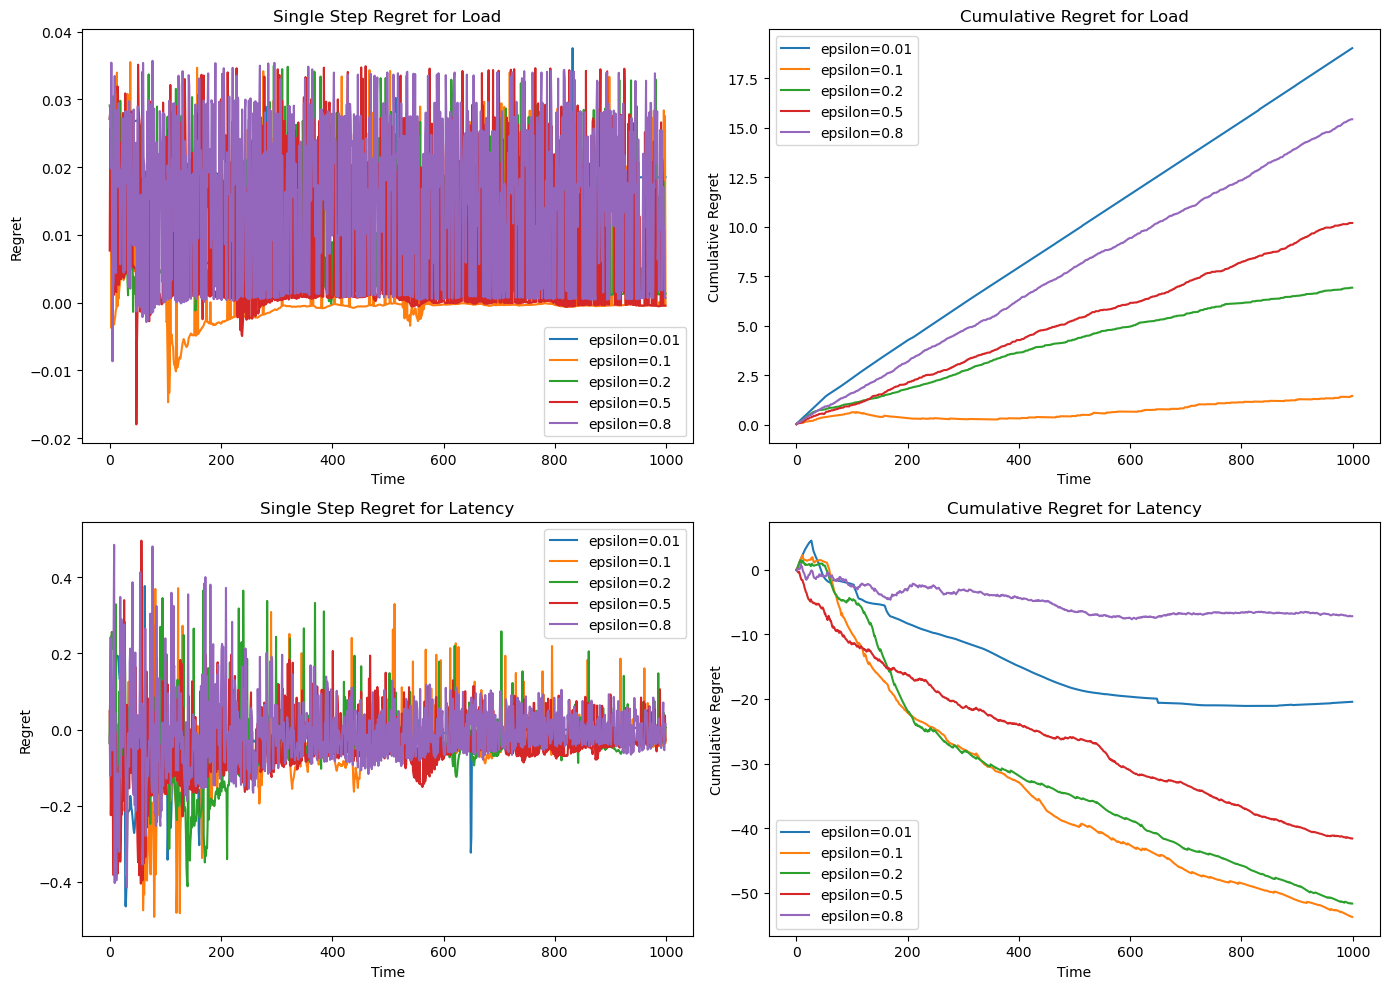

In [6]:
# Function to run epsilon-greedy algorithm and compute regrets
def run_epsilon_greedy(epsilon):
    rewards_load = 1 / (1 + load)
    rewards_latency = np.exp(-alpha * latency)

    estimated_means_load = np.zeros(N)
    estimated_means_latency = np.zeros(N)
    chosen_counts_load = np.zeros(N)
    chosen_counts_latency = np.zeros(N)

    cumulative_regret_load = np.zeros(T)
    cumulative_regret_latency = np.zeros(T)
    single_step_regret_load = np.zeros(T)
    single_step_regret_latency = np.zeros(T)

    for t in range(T):
        chosen_node_load = epsilon_greedy(epsilon, rewards_load[:, t], estimated_means_load)
        chosen_node_latency = epsilon_greedy(epsilon, rewards_latency[:, t], estimated_means_latency)

        reward_load = rewards_load[chosen_node_load, t]
        reward_latency = rewards_latency[chosen_node_latency, t]

        chosen_counts_load[chosen_node_load] += 1
        chosen_counts_latency[chosen_node_latency] += 1

        estimated_means_load[chosen_node_load] += (reward_load - estimated_means_load[chosen_node_load]) / chosen_counts_load[chosen_node_load]
        estimated_means_latency[chosen_node_latency] += (reward_latency - estimated_means_latency[chosen_node_latency]) / chosen_counts_latency[chosen_node_latency]

        single_step_regret_load[t] = calculate_regret(np.mean(rewards_load, axis=1), estimated_means_load[chosen_node_load])
        single_step_regret_latency[t] = calculate_regret(np.mean(rewards_latency, axis=1), estimated_means_latency[chosen_node_latency])

        if t == 0:
            cumulative_regret_load[t] = single_step_regret_load[t]
            cumulative_regret_latency[t] = single_step_regret_latency[t]
        else:
            cumulative_regret_load[t] = cumulative_regret_load[t - 1] + single_step_regret_load[t]
            cumulative_regret_latency[t] = cumulative_regret_latency[t - 1] + single_step_regret_latency[t]

    return single_step_regret_load, cumulative_regret_load, single_step_regret_latency, cumulative_regret_latency

# Epsilon-greedy algorithm
epsilon_values = [0.01, 0.1, 0.2, 0.5, 0.8]
alpha = 1.0

results = {epsilon: run_epsilon_greedy(epsilon) for epsilon in epsilon_values}

# Plotting all four graphs in a single figure
plt.figure(figsize=(14, 10))

# Single Step Regret for Load
plt.subplot(2, 2, 1)
for epsilon in epsilon_values:
    plt.plot(results[epsilon][0], label=f'epsilon={epsilon}')
plt.title('Single Step Regret for Load')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.legend()

# Cumulative Regret for Load
plt.subplot(2, 2, 2)
for epsilon in epsilon_values:
    plt.plot(results[epsilon][1], label=f'epsilon={epsilon}')
plt.title('Cumulative Regret for Load')
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.legend()

# Single Step Regret for Latency
plt.subplot(2, 2, 3)
for epsilon in epsilon_values:
    plt.plot(results[epsilon][2], label=f'epsilon={epsilon}')
plt.title('Single Step Regret for Latency')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.legend()

# Cumulative Regret for Latency
plt.subplot(2, 2, 4)
for epsilon in epsilon_values:
    plt.plot(results[epsilon][3], label=f'epsilon={epsilon}')
plt.title('Cumulative Regret for Latency')
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
import numpy as np

# 生成符合平均值为 λ^-1 的指数分布的随机数
lambda_value = 1  # 设置 λ 值
n_samples = 1000  # 生成的样本数
latency = np.random.exponential(scale=1/lambda_value, size=n_samples)


In [4]:
# 设置 AR(1) 系数 φ
phi = 0.8

# 初始化 AR(1) 模型的序列
ar1_series = np.zeros(n_samples)
ar1_series[0] = latency[0]  # 初始值

# 生成 AR(1) 序列
for t in range(1, n_samples):
    ar1_series[t] = phi * ar1_series[t-1] + latency[t]


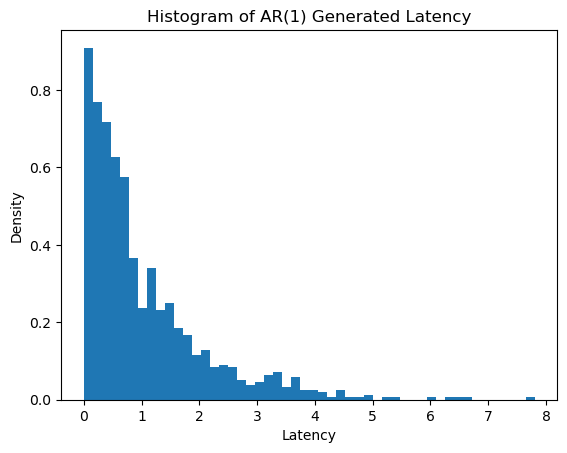

In [6]:
import matplotlib.pyplot as plt

plt.hist(latency, bins=50, density=True)
plt.title("Histogram of AR(1) Generated Latency")
plt.xlabel("Latency")
plt.ylabel("Density")
plt.show()


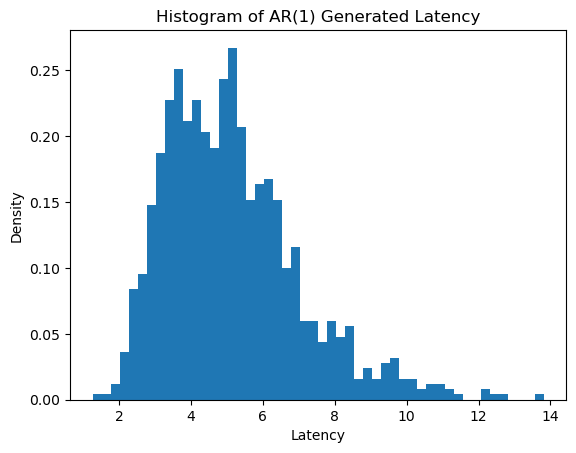

In [5]:
import matplotlib.pyplot as plt

plt.hist(ar1_series, bins=50, density=True)
plt.title("Histogram of AR(1) Generated Latency")
plt.xlabel("Latency")
plt.ylabel("Density")
plt.show()
